In [1]:
from dataset_lasot import DatasetLaSOT
from model import SiameseTracker
from loss import compute_loss
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime
import json
import sys
import copy
import os
from draw_samples_training import draw_samples_training

%matplotlib inline

In [2]:
# DATASET PARAMETERS
DIR_DATA = '/home/rafa/deep_learning/datasets/LaSOT' # Root to the folder with the prepared data
SIZE_TEMPLATE = 127
SIZE_SEARCH = 255
SIZE_OUT = 25
MAX_FRAME_SEP = 10
NEG_PROB = 0.475
EXTRA_CONTEXT_TEMPLATE = 0.5
MIN_EXTRA_CONTEXT_SEARCH = 0.75
MAX_EXTRA_CONTEXT_SEARCH = 1.5
MAX_SHIFT = 32
    
# MODEL PARAMETERS
BATCH_SIZE = 32

# TRAINING PARAMETERS
THRESHOLD_CLS = 0.5
ALPHA_LOSS = 0.25
GAMMA_LOSS = 2.0
WEIGHT_LOSS = 1.0

LEARNING_RATE = 0.001
NUM_EPOCHS = 15
NUM_SAMPLES_PLOT = 3

LOAD_MODEL = True
MODEL_PATH = 'results/2025-07-28_23-33-30/model.pth'

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

train_set = DatasetLaSOT("train", DIR_DATA, SIZE_TEMPLATE, SIZE_SEARCH, SIZE_OUT, MAX_FRAME_SEP, 
                                 NEG_PROB, EXTRA_CONTEXT_TEMPLATE, MIN_EXTRA_CONTEXT_SEARCH, MAX_EXTRA_CONTEXT_SEARCH, MAX_SHIFT)
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)


model = SiameseTracker(SIZE_TEMPLATE, SIZE_SEARCH, SIZE_OUT).to(device)

if LOAD_MODEL:
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Model successfully loaded!")

n_params = sum([p.numel() for p in model.parameters()])
print("Total number of parameters: ", n_params)
n_params_backbone = sum([p.numel() for p in model.backbone.parameters()])
print("Number parameters backbone: ", n_params_backbone)
n_params_cross_attn = sum([p.numel() for p in model.cross_attn.parameters()])
print("Number parameters cross attn: ", n_params_cross_attn)
n_params_cls = sum([p.numel() for p in model.cls_head.parameters()])
print("Number parameters classification: ", n_params_cls)
n_params_reg = sum([p.numel() for p in model.wh_head.parameters()])
print("Number parameters regression: ", n_params_reg)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using device:  cuda


/home/rafa/anaconda3/envs/siam_tracking/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rafa/anaconda3/envs/siam_tracking/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model successfully loaded!
Total number of parameters:  47635523
Number parameters backbone:  23508032
Number parameters cross attn:  4198400
Number parameters classification:  9439233
Number parameters regression:  9440258


  0%|                                | 0/88500 [00:00<?, ?it/s]

Epoch 1, batch 0, Loss: 0.12179606407880783, cls loss: 0.05076479911804199, regression loss: 0.07103126496076584


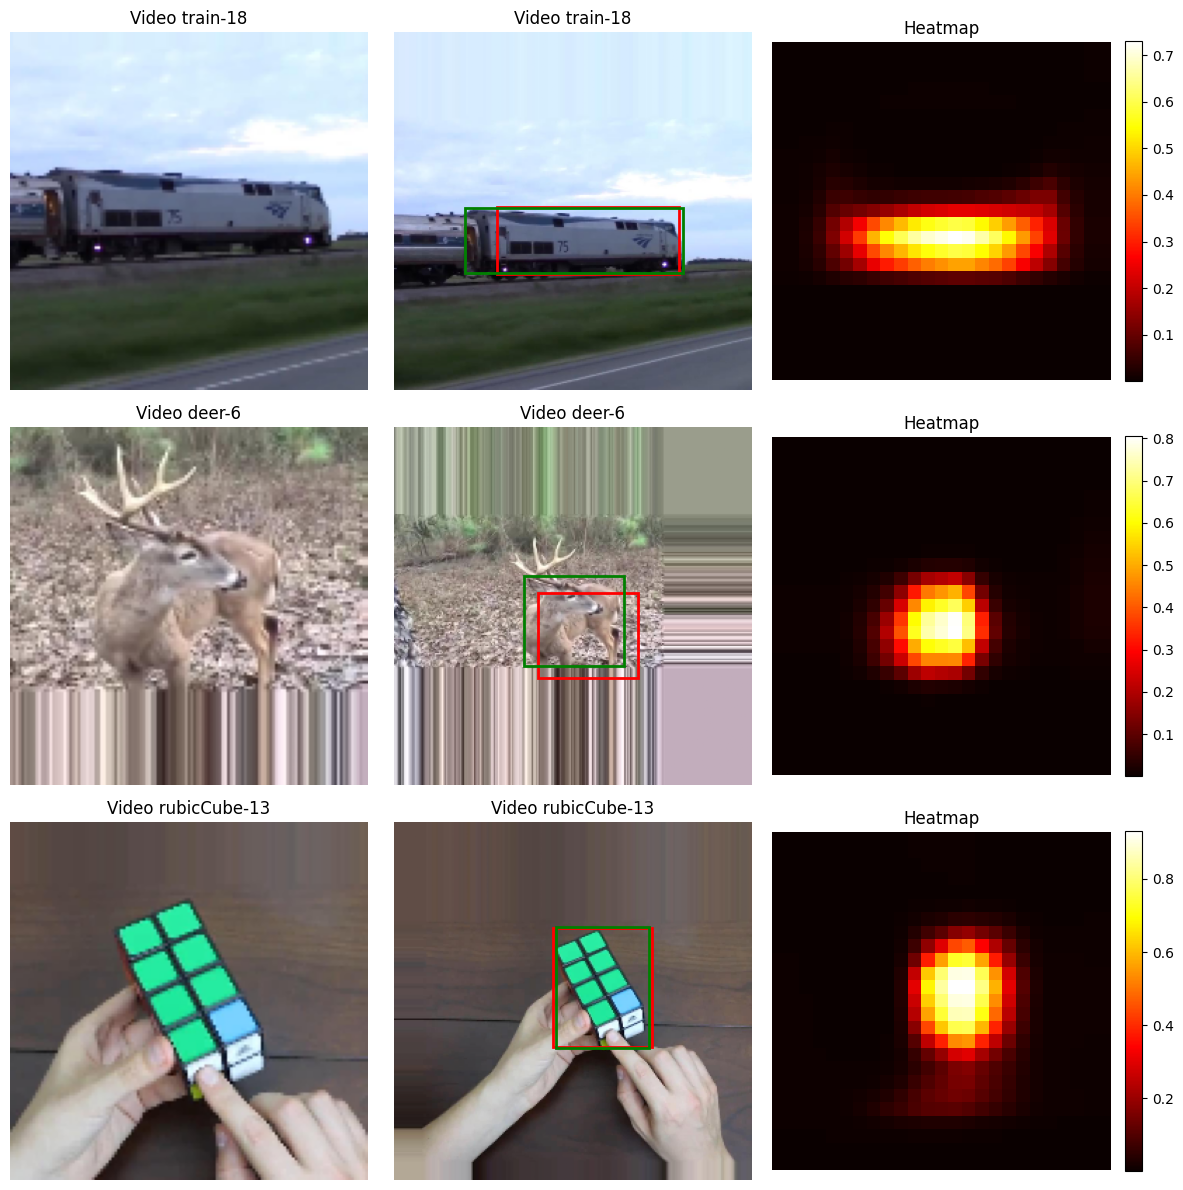

  0%|                     | 50/88500 [00:19<9:23:32,  2.62it/s]

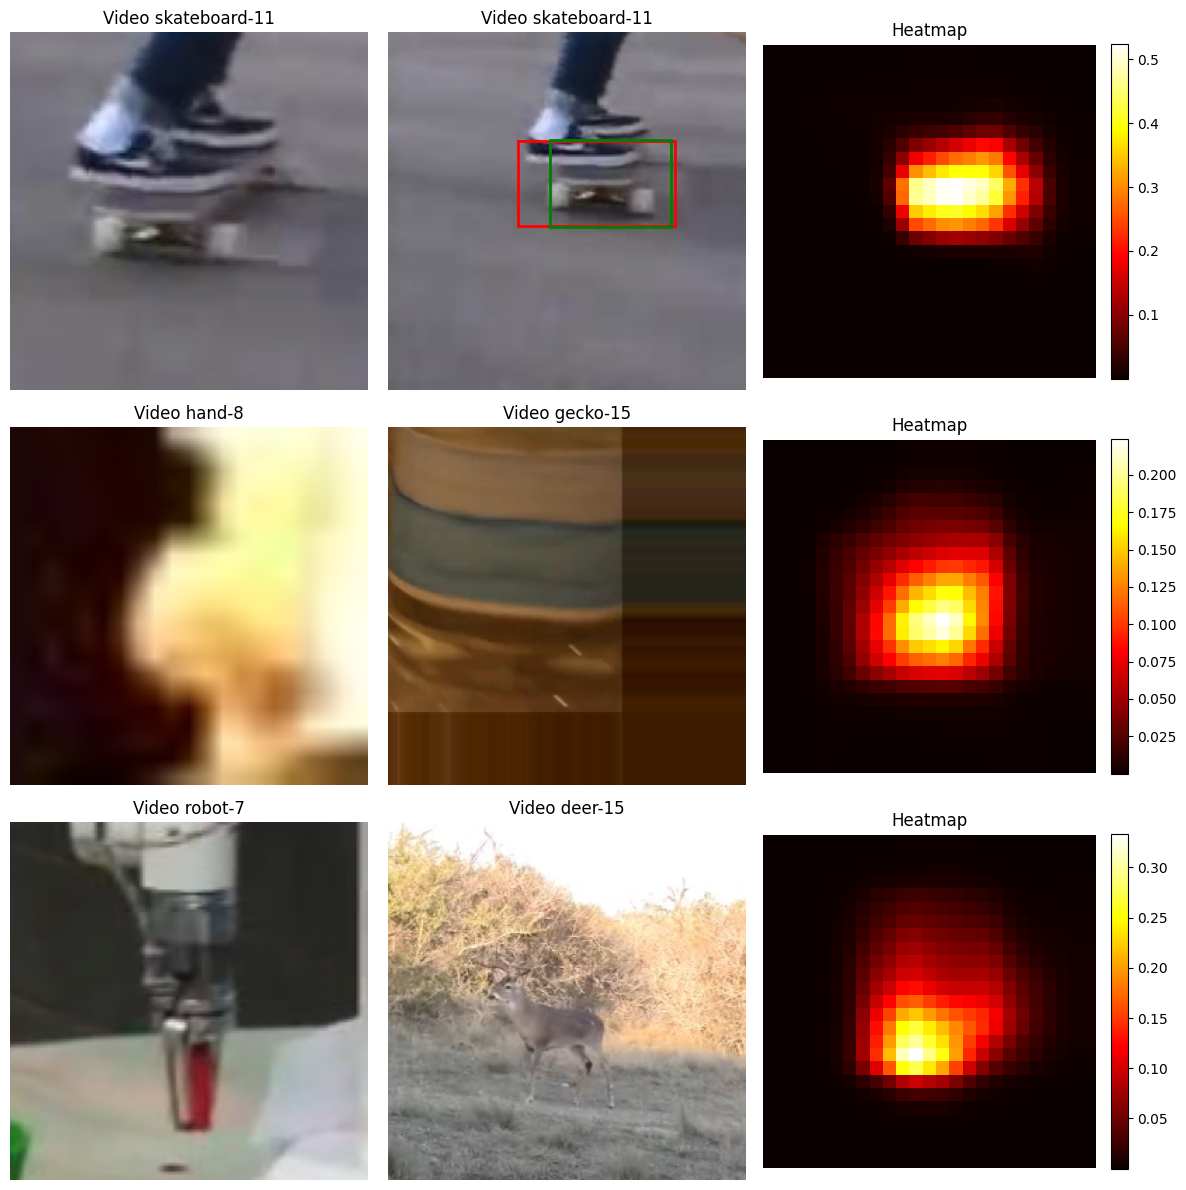

  0%|                     | 95/88500 [00:36<9:02:21,  2.72it/s]/home/rafa/deep_learning/projects/siam_tracking/training/dataset_lasot.py:300: RuntimeWarning: invalid value encountered in divide
  heatmap /= heatmap.max()
  0%|                    | 100/88500 [00:38<9:11:53,  2.67it/s]

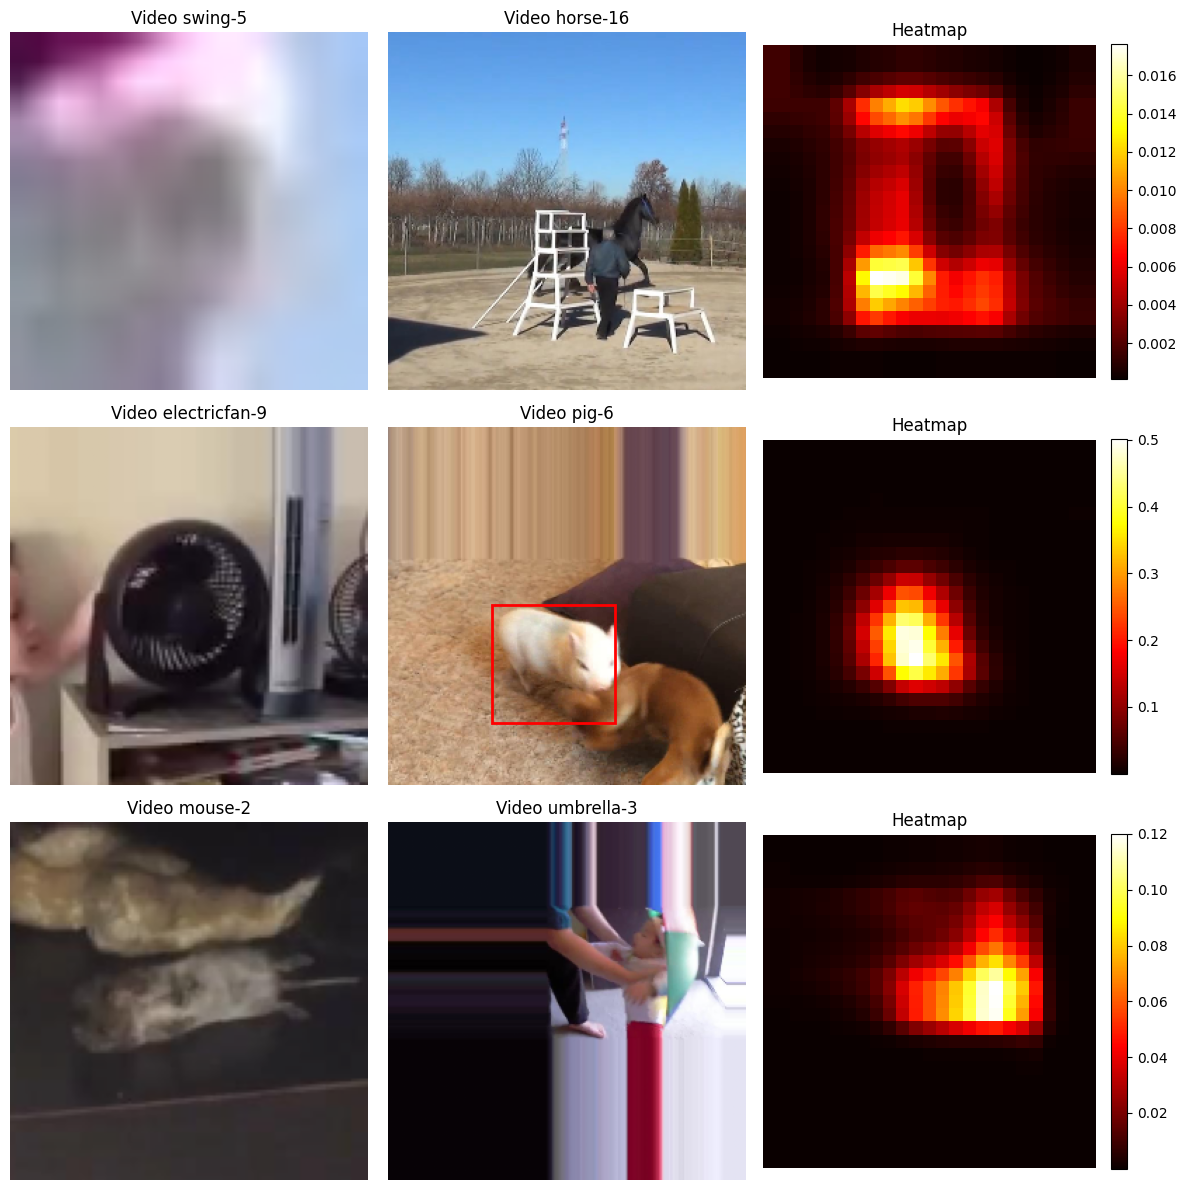

  0%|                    | 150/88500 [00:57<8:51:06,  2.77it/s]

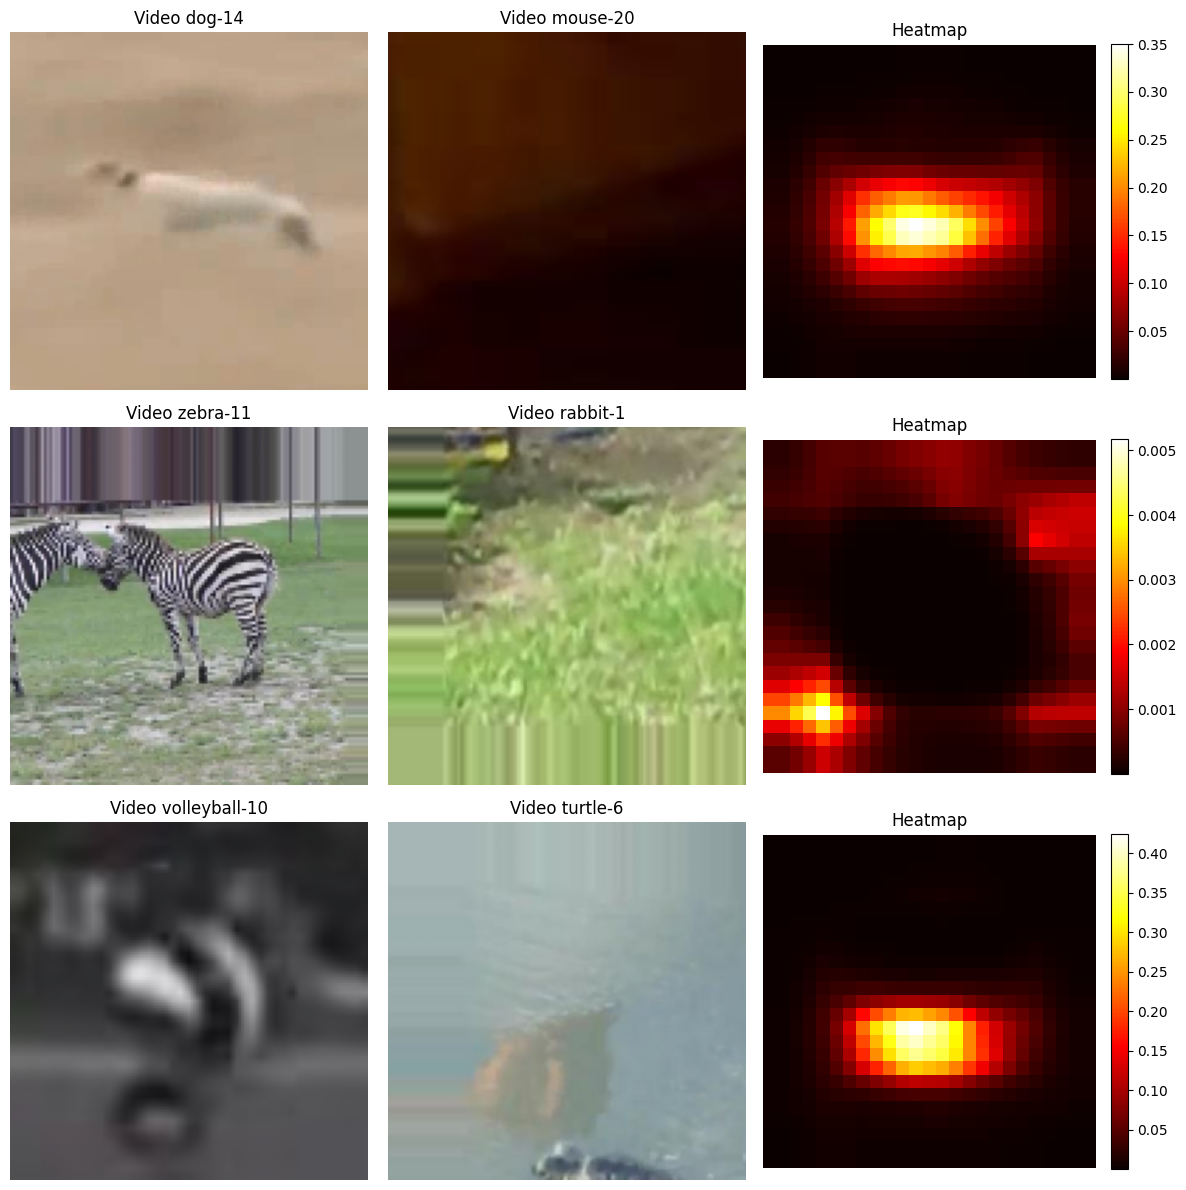

  0%|                    | 187/88500 [01:12<9:30:46,  2.58it/s]


KeyboardInterrupt: 

In [3]:
for epoch in range(NUM_EPOCHS):
    ##################### TRAIN #######################
    model.train()
    train_loss = 0.0
    
    for batch_idx, (template, search, heatmap, bbox, video_template_name, video_search_name) in enumerate(tqdm(train_dataloader)):
        template, search, heatmap, bbox = template.to(device, dtype=torch.float), search.to(device, dtype=torch.float), heatmap.to(device, dtype=torch.float), bbox.to(device, dtype=torch.float)
           
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        pred_heatmap, pred_bbox = model(template, search)
        
        # Calculate loss
        loss = compute_loss(pred_heatmap, pred_bbox, heatmap, bbox)
        
        # Backward pass
        loss[0].backward()
        
        # Optimize
        optimizer.step()
        
        train_loss += loss[0].item()

        if (batch_idx % 1000 == 0):
            print(f"Epoch {epoch+1}, batch {batch_idx}, Loss: {train_loss/(batch_idx+1)}, cls loss: {loss[1].item()}, regression loss: {loss[2].item()}")

        if (batch_idx % 50 == 0):
            draw_samples_training(template, search, torch.sigmoid(pred_heatmap), pred_bbox, heatmap, bbox, train_set.mean, train_set.std, THRESHOLD_CLS, NUM_SAMPLES_PLOT, video_template_name, video_search_name)
    
    train_loss /= float(batch_idx+1)

print("Training finished.")

In [ ]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_path = f"results/{current_date}"
os.makedirs(folder_path, exist_ok=True)
model_path = os.path.join(folder_path,f"model.pth")
torch.save(model.state_dict(), model_path)

In [1]:
train_set.visualize_video('train-18')

NameError: name 'train_set' is not defined